# percent-allocate

Maintain a percent allocation of a security in account  
(1) If close > 200dma, maintain share percentage between 46.5% and 53.5%.  
(2) If close < 200dma, close out position

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 50
band = 3

sma200_band = 3.5

Define Strategy Class 

In [6]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        pf.TradeLog.cash = self._capital

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self._ts, i)
            shares = 0

            # adjust shares
            if ((self._tlog.share_percent(close) > target_percent+band or
                self._tlog.share_percent(close) < target_percent-band)
                and row.regime > 0
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent)   
            # close out
            elif (row.regime < 0
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end, use_adj=True)

        # Add technical indicator: 200 sma regime filter
        self._ts['regime'] = \
            pf.CROSSOVER(self._ts, timeperiod_fast=1, timeperiod_slow=200, band=sma200_band)
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._tlog = pf.TradeLog(self._symbol)
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
35,2015-08-21,35,179.10,80,exit,LONG,SPY
36,2016-04-01,36,190.40,77,entry,LONG,SPY
37,2017-02-13,37,217.67,5,exit,LONG,SPY
38,2017-11-28,38,249.32,5,exit,LONG,SPY
39,2018-10-29,39,254.83,67,exit,LONG,SPY
40,2019-03-18,40,275.46,62,entry,LONG,SPY
41,2019-12-12,41,312.36,4,exit,LONG,SPY
42,2020-03-09,42,271.43,58,exit,LONG,SPY
43,2020-06-03,43,310.81,54,entry,LONG,SPY
44,2020-07-23,44,322.28,54,exit,LONG,SPY


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
24,2012-01-10,108.94,2013-05-15,143.89,34.95,209.71,6,13118.22,LONG,SPY
25,2012-01-10,108.94,2014-02-28,163.89,54.95,329.71,6,13447.93,LONG,SPY
26,2012-01-10,108.94,2015-02-17,188.46,79.52,397.60,5,13845.52,LONG,SPY
27,2012-01-10,108.94,2015-08-21,179.10,70.16,5613.08,80,19458.61,LONG,SPY
28,2016-04-01,190.40,2017-02-13,217.67,27.26,136.32,5,19594.92,LONG,SPY
29,2016-04-01,190.40,2017-11-28,249.32,58.92,294.58,5,19889.50,LONG,SPY
30,2016-04-01,190.40,2018-10-29,254.83,64.42,4316.34,67,24205.84,LONG,SPY
31,2019-03-18,275.46,2019-12-12,312.36,36.89,147.58,4,24353.42,LONG,SPY
32,2019-03-18,275.46,2020-03-09,271.43,-4.03,-233.86,58,24119.56,LONG,SPY
33,2020-06-03,310.81,2020-07-23,322.28,11.47,619.26,54,24738.82,LONG,SPY


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-17,34754.48,34601.66,34708.58,54,17335.70,1.00,-
2020-07-20,34892.72,34649.18,34848.98,54,17335.70,1.00,-
2020-07-21,34989.92,34828.46,34886.24,54,17335.70,1.00,-
2020-07-22,35004.50,34858.70,34986.14,54,17335.70,1.00,-
2020-07-23,34738.82,34738.82,34738.82,0,34738.82,1.00,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2020-07-23
beginning_balance                                            10000
ending_balance                                            34738.82
total_net_profit                                          24738.82
gross_profit                                              25191.50
gross_loss                                                 -452.67
profit_factor                                                55.65
return_on_initial_capital                                   247.39
annual_return_rate                                            4.77
trading_period                           26 years 8 months 12 days
pct_time_in_market                                           75.22
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2020-07-23 00:00:00 SELL 215 SPY @ 322.28


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                   1993-11-11
end                                                     2020-07-23
beginning_balance                                            10000
ending_balance                                            69319.57
total_net_profit                                          59319.57
gross_profit                                              59319.57
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                   593.20
annual_return_rate                                            7.52
trading_period                           26 years 8 months 12 days
pct_time_in_market                                          100.00
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Plot Equity Curves: Strategy vs Benchmark

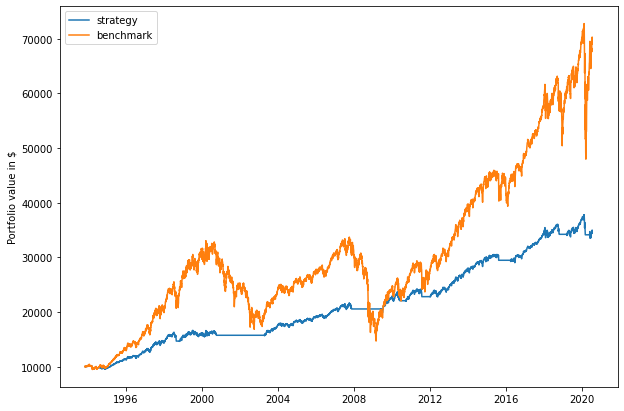

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

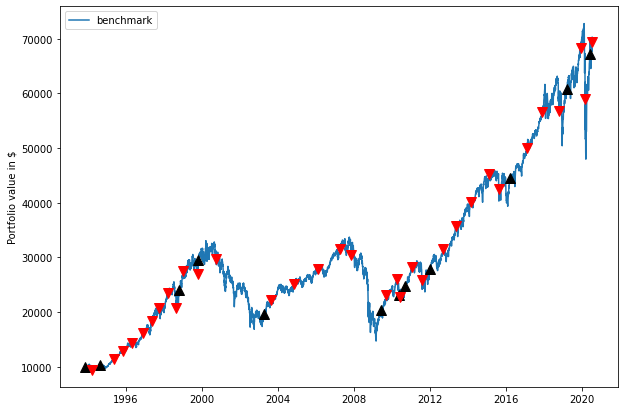

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,4.77,7.52
max_closed_out_drawdown,-11.38,-56.42
drawdown_annualized_return,-2.38,-7.50
drawdown_recovery,-0.31,-1.42
best_month,7.55,23.06
worst_month,-9.74,-31.38
sharpe_ratio,0.78,0.48
sortino_ratio,0.85,0.60
monthly_std,1.59,4.54


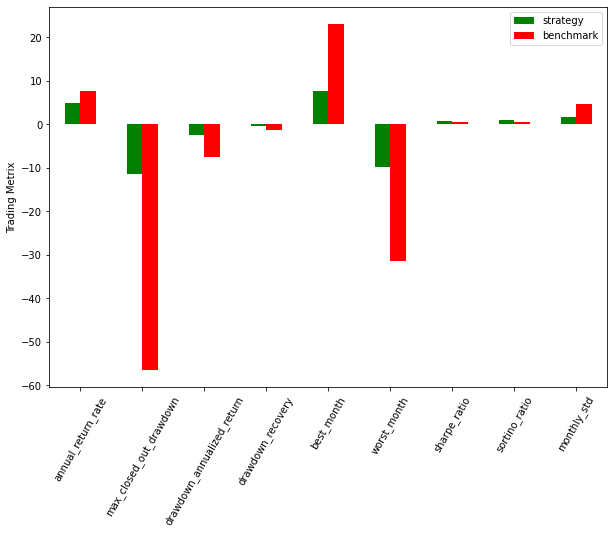

In [18]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df